# Exploring different ways of creating edge weights
* Distance to regression line created from reference data
* Sum of node weights
* Euclidean distance of node weights to 0
* Euclidean distance of node weights to 0 if both > 0 (i.e. both genes overexpressed compared to the mean of the data), 0 otherwise (edge is considered "off").

In [4]:
import h5py
import numpy as np

In [5]:
%pylab inline
orange_color = '#d66000'
blue_color = '#005599'

Populating the interactive namespace from numpy and matplotlib


## Read RFS data

In [6]:
f = h5py.File("ACES/experiments/data/U133A_combat.h5")
f.keys()
X = f['U133A_combat_RFS']['ExpressionData']

In [7]:
print X.shape
print X.dtype

(1616, 12750)
float64


In [8]:
y = np.array(f['U133A_combat_RFS']['PatientClassLabels'], dtype='int')
print y.shape

(1616,)


In [11]:
aces_gene_names =  np.array(f['U133A_combat_RFS']['GeneLabels'])
aces_gene_names = list(aces_gene_names)

## Load edges (skeleton)

In [12]:
edges_set = set([]) # (gene_idx_1, gene_idx_2)
# gene_idx_1 < gene_idx_2
# idx in aces_gene_names, starting at 0
with open('ACES/experiments/data/KEGG_edges1210.sif') as f:
    for line in f:
        ls = line.split()
        gene_name_1 = 'Entrez_%s' % ls[0]
        gene_name_2 = 'Entrez_%s' % ls[2]
        # Exclude self edges
        if gene_name_1 == gene_name_2:
            continue 
        try:
            gene_idx_1 = aces_gene_names.index(gene_name_1)  
            gene_idx_2 = aces_gene_names.index(gene_name_2)
        except ValueError:
            continue
        if gene_idx_1 < gene_idx_2:
            e = (gene_idx_1, gene_idx_2)
        else:
            e = (gene_idx_2, gene_idx_1)
        edges_set.add(e)
    f.close()  

In [13]:
np.savetxt('KEGG_edges.txt', np.array([list(x) for x in list(edges_set)]), fmt='%d')

In [14]:
print len(edges_set), "edges in total."
edges_list = np.array(list(edges_set))

genes_in_network = set(np.array([list(x) for x in list(edges_set)]).flatten())
print len(genes_in_network), "genes in the network."

22178 edges in total.
3238 genes in the network.


In [20]:
# Restrict X to the genes that are in the network 
genes_in_network = list(genes_in_network)
genes_in_network.sort()
X_in_ntwk = X[:, genes_in_network]
print X_in_ntwk.shape

(1616, 3238)


In [22]:
print(list(edges_set)[:10])

[(6112, 7489), (1312, 2811), (5325, 11299), (3775, 12357), (3800, 4921), (8780, 9929), (3351, 8587), (3267, 10258), (2049, 5427), (4643, 12087)]


## Regline

Distance from (x, y) to line: 
$\frac{|w_0 x + w_1 - y|}{\sqrt{w_0^2+1}}$

In [23]:
def dist_to_line(x0, y0, w0, w1):
    #return (np.abs(w1*x0 - y0 + w0)/np.sqrt(w1**2+1))
    return (np.abs(w0*x0 - y0 + w1)/np.sqrt(w0**2+1))

### Read reference data

In [24]:
g = h5py.File("ArrayExpress/postproc/MTAB-62.h5")
Xref = g['MTAB-62']['ExpressionData']

In [25]:
print Xref.shape
print Xref.dtype

(1033, 12750)
float64


In [30]:
print aces_gene_names[:10]
ntwk_gene_names = [aces_gene_names[i] for i in genes_in_network]
print ntwk_gene_names[:10]

['Entrez_780', 'Entrez_5982', 'Entrez_7318', 'Entrez_2049', 'Entrez_4323', 'Entrez_8717', 'Entrez_441263', 'Entrez_572', 'Entrez_10594', 'Entrez_826']
['Entrez_7318', 'Entrez_2049', 'Entrez_4323', 'Entrez_8717', 'Entrez_572', 'Entrez_1072', 'Entrez_1603', 'Entrez_387', 'Entrez_3326', 'Entrez_2987']


In [34]:
# Reorder reference data so that genes match
refc_gene_names = g['MTAB-62']['GeneLabels']
refc_gene_names = list(refc_gene_names)
#refc_gene_names_dict = dict([(a, ix) for ix, a in enumerate(refc_gene_names)]) # name:idx
#reordered_genes = [refc_gene_names_dict[a] for a in ntwk_gene_names]
#reordered_genes = [ntwk_gene_names.index(gene) for gene in refc_gene_names]
reordered_genes = [refc_gene_names.index(gene) for gene in ntwk_gene_names]
print reordered_genes[:10]

[2, 2500, 3, 4, 6, 22, 42, 53, 57, 62]


In [42]:
#Xr = np.array(Xref)
Xr = np.zeros((Xref.shape[0], X_in_ntwk.shape[1]))
for ix in range(Xref.shape[1]):
    # if we keep that index
    if ix < len(reordered_genes):
        Xr[:, ix] = Xref[:, reordered_genes[ix]]

In [43]:
print Xr.shape

(1033, 3238)


In [ ]:
# Normalize data
#x_mean = np.mean(Xr, axis=0)
#x_stdv = np.std(Xr, axis=0, ddof=1)
#Xr -= x_mean
#Xr /= x_stdv

#X_in_ntwk -= x_mean
#X_in_ntwk /= x_stdv

In [45]:
idx_1 = edges_list[-1][0]
idx_2 = edges_list[-1][1]
n, p = Xr.shape
reg_wr = np.linalg.lstsq(np.array([ Xr[:, idx_1], np.ones(n) ]).T, Xr[:, idx_2])[0]

In [46]:
[w0, w1] = reg_wr
print w0, w1

0.0593453983242 7.81362689601e-15


In [48]:
e_weights_1 = np.array([dist_to_line(X_in_ntwk[q, idx_1], X_in_ntwk[q, idx_2], w0, w1) \
                        for q in range(X_in_ntwk.shape[0])])

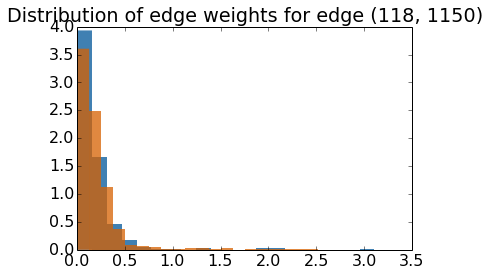

In [52]:
h=hist(e_weights_1[y==1], bins=20, normed=True, edgecolor='none', 
            color=blue_color, alpha=0.75)
h=hist(e_weights_1[y==0], bins=20, normed=True, edgecolor='none', 
            color=orange_color, alpha=0.75)
title('Distribution of edge weights for edge (%d, %d)' % (idx_1, idx_2))

In [53]:
# Point that's furthest from the line
print np.max(e_weights_1)
sample_idx = np.where(e_weights_1==np.max(e_weights_1))[0][0]
print sample_idx

3.1087184665
1483


1.36113075375 3.19496476275


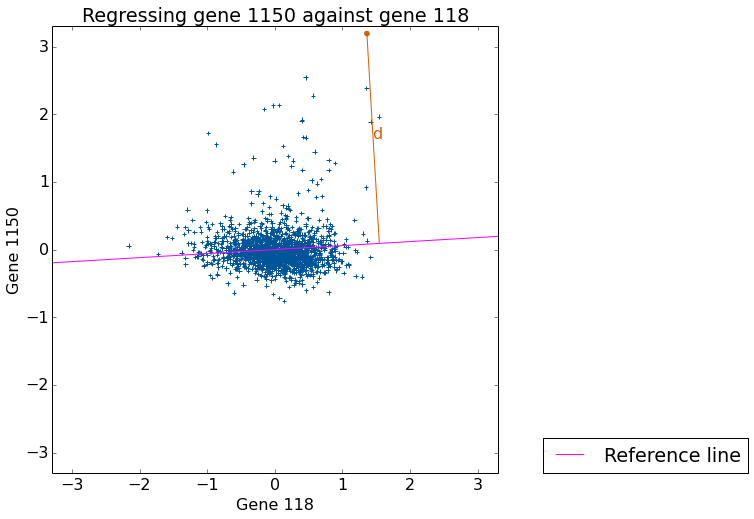

In [57]:
rcParams.update({'font.size': 16})
figure(figsize=(8, 8))
plt.scatter(X_in_ntwk[:, idx_1], X_in_ntwk[:, idx_2], marker="+", color=blue_color)
plot(np.arange(-5, 5, 0.1),  w0*np.arange(-5, 5, 0.1) + w1, 
     ls='-', color='magenta', label='Reference line')
xlim(-3.3, 3.3)
ylim(-3.3, 3.3)
xlabel('Gene %d' % idx_1)
ylabel('Gene %d' % idx_2)
title('Regressing gene %d against gene %d' % (idx_2, idx_1))

# single out the point that's farthest from the line
x0 = X_in_ntwk[sample_idx, idx_1]
y0 = X_in_ntwk[sample_idx, idx_2]
print x0, y0
plt.scatter(x0, y0, marker="o", color=orange_color)
a = (w0 * (y0 - w1) + x0)/(1 + w0**2)
b = (w1 + w0 * (x0 + w0 * y0))/(1 + w0**2)
plot([x0, a], [y0, b], ls='-', color=orange_color)
text(0.5*(x0+a), 0.5*(y0+b), 'd', color=orange_color)

plt.legend(loc=(1.1, 0))

#savefig('regline_example.pdf', bbox='tight_layout')

### SUM

In [58]:
e_weights_2 = np.array([X_in_ntwk[q, idx_1] + X_in_ntwk[q, idx_2] \
                        for q in range(X_in_ntwk.shape[0])])

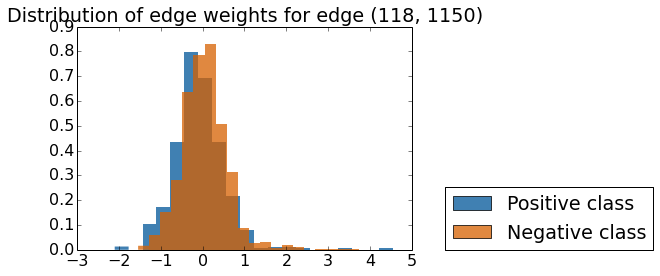

In [59]:
h=hist(e_weights_2[y==1], bins=20, normed=True, edgecolor='none', 
            color=blue_color, alpha=0.75, label="Positive class")
h=hist(e_weights_2[y==0], bins=20, normed=True, edgecolor='none', 
            color=orange_color, alpha=0.75, label="Negative class")
title('Distribution of edge weights for edge (%d, %d)' % (idx_1, idx_2))
plt.legend(loc=(1.1, 0))

### EUCLIDE

In [61]:
e_weights_3 = np.array([(0.5 * np.sqrt(X_in_ntwk[q, idx_1]**2 + X_in_ntwk[q, idx_2]**2)) \
                        for q in range(X_in_ntwk.shape[0])])

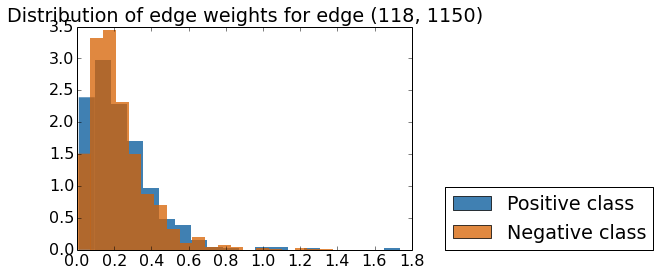

In [62]:
h=hist(e_weights_3[y==1], bins=20, normed=True, edgecolor='none', 
            color=blue_color, alpha=0.75, label="Positive class")
h=hist(e_weights_3[y==0], bins=20, normed=True, edgecolor='none', 
            color=orange_color, alpha=0.75, label="Negative class")
title('Distribution of edge weights for edge (%d, %d)' % (idx_1, idx_2))
plt.legend(loc=(1.1, 0))

## EUCLIDE with threshold

In [70]:
print X_in_ntwk[:, idx_1]>0
print X_in_ntwk[:, idx_2]>0
print (X_in_ntwk[:, idx_1]>0)*(X_in_ntwk[:, idx_2]>0) 

[False  True False ...,  True  True False]
[False  True  True ..., False False False]
[False  True False ..., False False False]


In [71]:
e_weights_4 = np.where((X_in_ntwk[:, idx_1]>0) * (X_in_ntwk[:, idx_2]>0),
                       np.array([(0.5 * np.sqrt(X_in_ntwk[q, idx_1]**2 + X_in_ntwk[q, idx_2]**2)) \
                        for q in range(X_in_ntwk.shape[0])]),
                       0)

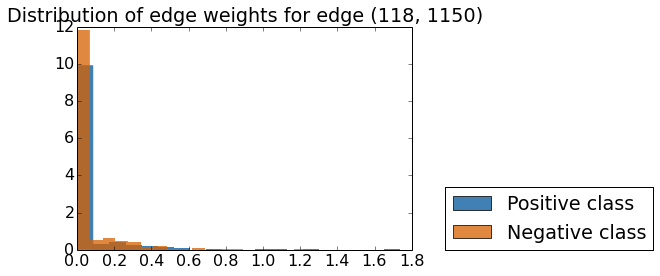

In [72]:
h=hist(e_weights_4[y==1], bins=20, normed=True, edgecolor='none', 
            color=blue_color, alpha=0.75, label="Positive class")
h=hist(e_weights_4[y==0], bins=20, normed=True, edgecolor='none', 
            color=orange_color, alpha=0.75, label="Negative class")
title('Distribution of edge weights for edge (%d, %d)' % (idx_1, idx_2))
plt.legend(loc=(1.1, 0))